In [1]:
def simply(ox,oy,p):
    ox1 = [0]
    oy1 = [0]
    for i in range((max(ox)-min(ox))//p + 1):
        ox1[i] = min(ox) + p*i//2
        oy1[i] = sum(oy[i*p:(1+i)*p])
        ox1.append(0)
        oy1.append(0)
    return(ox1,oy1)

# мини функция для более аккуратных и красивых графиков (используется всего пару раз)

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

Посмотрим на задание:
1) Большинство создаваемых гильдий не активны
2) Игроки, покупающие премиум товары, создают более активные гильдии, поскольку, инвестируя в игру, пользователь больше ценит вложенные усилия
3) Если первое предположение верно, стоит ли существенно повысить стоимость создания гильдии, в том числе сделать это премиум товаром (за реальные деньги)

In [3]:
df1 = pd.read_csv('guild_data.csv')
df1.head(3)

,datetime,creator_character_id,guild_id,n_added_characters,n_removed_characters,n_talents,level,n_missions_completed,n_times_flag_turned_on,mean_place,mean_rating,n_seasons
0,2022-12-12 23:13:42,15092203,78698,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-12 22:29:09,15961764,78604,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-12 21:01:53,16187808,78510,27,19.0,9.0,2.0,171.0,NaN,NaN,NaN,NaN


Есть: дата создания гильдии, айди персонажа, создавшего гильдию, айдишник гильдии, количество приглашенных, количество исключенных, количество талантов, уровень, количество выполненых миссий, количество участий в войне гильдий, место в войне гильдий, рейтинг в войне гильдий, количество сезонов войн.

In [4]:
df2 = pd.read_csv('payers.csv')
df2.head(5)

,revenue,character_id
0,102.897877,13642352
1,105.839569,29703528
2,50.040612,28081545
3,18.044814,12663426
4,5.913989,16071934


Тут меньше данных, сумма энергии, айдишник гильдии, тип источника энергии

In [5]:
df1.isnull().sum()

datetime                    0
creator_character_id        0
guild_id                    0
n_added_characters          0
n_removed_characters       99
n_talents                 293
level                     393
n_missions_completed       70
n_times_flag_turned_on    884
mean_place                906
mean_rating               906
n_seasons                 906
dtype: int64

In [6]:
df1.count()

datetime                  965
creator_character_id      965
guild_id                  965
n_added_characters        965
n_removed_characters      866
n_talents                 672
level                     572
n_missions_completed      895
n_times_flag_turned_on     81
mean_place                 59
mean_rating                59
n_seasons                  59
dtype: int64

Подавляющее большинство гильдий не участвовало ни в одном сезоне, что уже может свидетельствовать о несильной активности в гильдиях

Проведем более тонкий анализ. Посмотрим, какое количество людей обычно постоит в гильдиях.


In [7]:
df1['Количество'] = df1['n_added_characters'] - df1['n_removed_characters']

In [10]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
a = (df1.groupby('Количество').size().to_numpy())[1:]
b = (df1.groupby('Количество').size().index.to_numpy())[1:]
print(a)
print(b)

[58 47 49 46 46 68 73 44 46 35 33 26 19 11  5  8  6  7  4  6  4  4  2]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23.]


<BarContainer object of 23 artists>

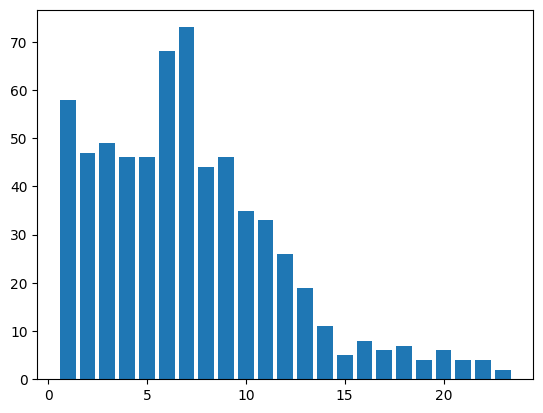

In [11]:
plt.bar(b, a)

In [12]:
#СРЕДНЕЕ ЗНАЧЕНИЕ ИГРОКОВ В ГИЛЬДИЯХ
print(df1['Количество'].mean())
print(df1[df1['Количество'] != 0]['Количество'].mean())

5.391454965357967
7.216383307573416


Можно сделать вывод: зачастую в гильдиях состоит от 3 до 9 человек. Гильдии из 2 человек и меньше тоже существуют, но это, вероятно уже нельзя назвать гильдиями. Гильдии из 10 и более человек тоже создаются, однако, вероятно, из-за недавности и нераспространенности гильдии еще не успели разрастись. 

137.64581005586592


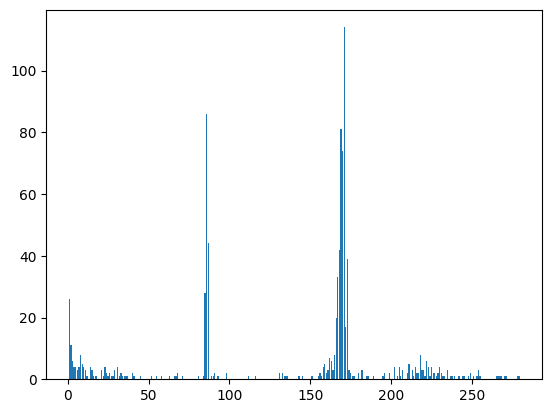

In [13]:
a = (df1.groupby('n_missions_completed').size().to_numpy())[:]
b = (df1.groupby('n_missions_completed').size().index.to_numpy())[:]
plt.bar(b, a)
print(df1['n_missions_completed'].mean())

Данный график показывает, что в игре существует несколько типов гильдий - начинающие или развалившиеся (от 0 до 50 выполненных миссий суммарно)
Гильдии не так давно пришедших - в районе 100 выполненных миссий. И гильдии давних игроков - от 150 до 250 выполненных миссий. 

Такое разделение вполне естественно, ибо начинающие игроки собираются отдельно от профессионалов.

Возможно игрокам нравятся одиночные миссии, но не нравятся коллективные ивенты. Проверим это далее.

In [14]:
df1['n_talents'].fillna(0, inplace=True)

C:\Users\ilyas\AppData\Local\Temp\ipykernel_4188\654178798.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['n_talents'].fillna(0, inplace=True)


10.739896373056995


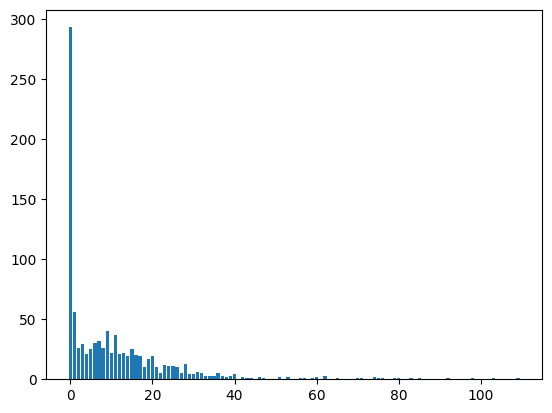

In [15]:
a = (df1.groupby('n_talents').size().to_numpy())[:]
b = (df1.groupby('n_talents').size().index.to_numpy())[:]
plt.bar(b, a)
print(df1['n_talents'].mean())

По предыдущим данным можно было сказать, что игроки весьма активны в игре. Однако, при проверке параметра, который отвечает за активность игроков в гильдиях замечается негативный тренд. Подавляющее большинство гильдий не набрали и двадцати талантов, что весьма скудно учитывая максимально возможные значения.

Более того - подавляющее большинство даже не открыло таланты. Если вырезать их, то график все равно лучше не станет.

10.739896373056995


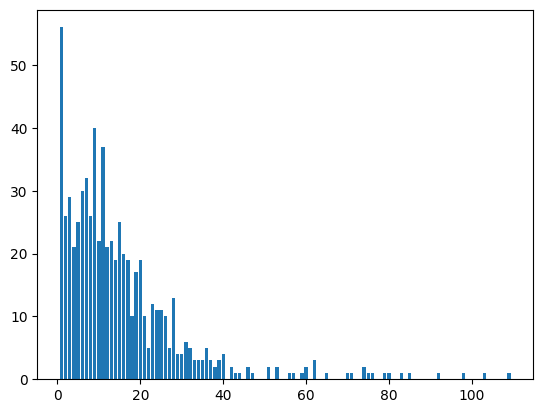

In [16]:
a = (df1.groupby('n_talents').size().to_numpy())[1:]
b = (df1.groupby('n_talents').size().index.to_numpy())[1:]
plt.bar(b, a)
print(df1['n_talents'].mean())
# ситуация все еще плачевная

Посмотри на данные по уровням, без учета начального уровня и с учетом.

3.097902097902098


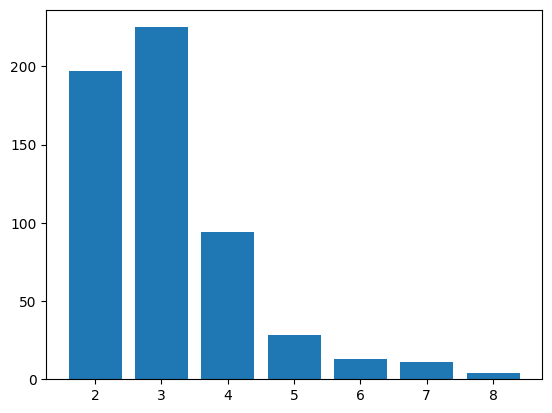

In [17]:
a = (df1.groupby('level').size().to_numpy())[:]
b = (df1.groupby('level').size().index.to_numpy())[:]
plt.bar(b, a)
print(df1['level'].mean())

In [18]:
df1['level'].fillna(1, inplace=True)

C:\Users\ilyas\AppData\Local\Temp\ipykernel_4188\515546791.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['level'].fillna(1, inplace=True)


2.243523316062176


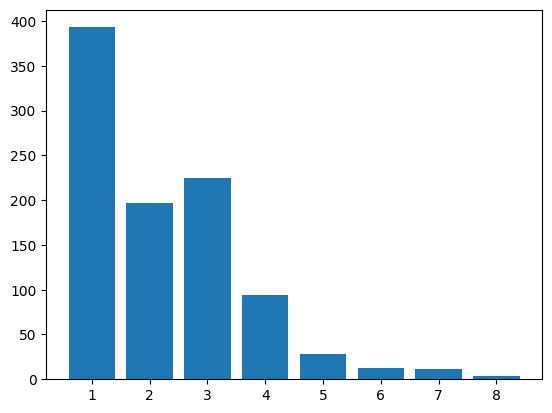

In [19]:
a = (df1.groupby('level').size().to_numpy())[:]
b = (df1.groupby('level').size().index.to_numpy())[:]
plt.bar(b, a)
print(df1['level'].mean())

Неожиданный результат. Или уровни получить очень легко, или гильдии нравятся людям.

C:\Users\ilyas\AppData\Local\Temp\ipykernel_4188\3991787954.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['n_times_flag_turned_on'].fillna(0, inplace=True)


<BarContainer object of 8 artists>

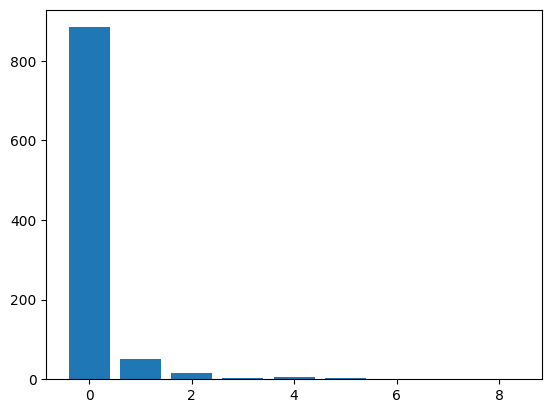

In [20]:
df1['n_times_flag_turned_on'].fillna(0, inplace=True)
a = (df1.groupby('n_times_flag_turned_on').size().to_numpy())[:]
b = (df1.groupby('n_times_flag_turned_on').size().index.to_numpy())[:]
plt.bar(b, a)

0.0922279792746114


C:\Users\ilyas\AppData\Local\Temp\ipykernel_4188\3248167959.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['n_seasons'].fillna(0, inplace=True)


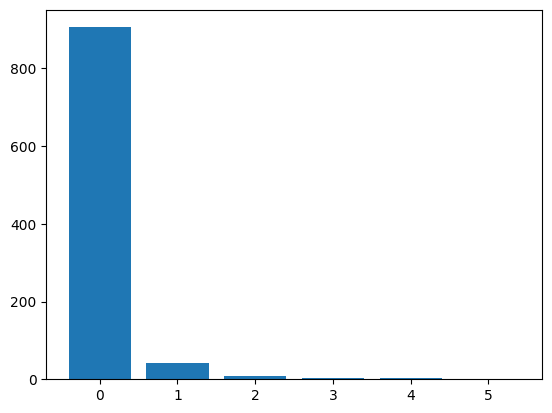

In [21]:
df1['n_seasons'].fillna(0, inplace=True)
a = (df1.groupby('n_seasons').size().to_numpy())[:]
b = (df1.groupby('n_seasons').size().index.to_numpy())[:]
plt.bar(b, a)
print(df1['n_seasons'].mean())

<BarContainer object of 5 artists>

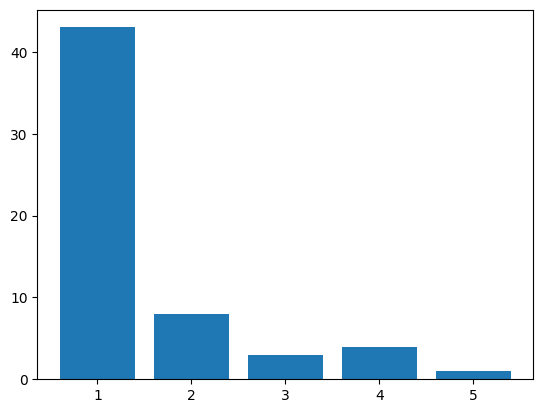

In [22]:
a = (df1.groupby('n_seasons').size().to_numpy())[1:]
b = (df1.groupby('n_seasons').size().index.to_numpy())[1:]
plt.bar(b, a)

Итого: вероятно пользователям нравятся индивидеальные плюшки, которые дают гильдиии, но им не нравится все, что связано с войнами кланов. 
Поэтому, уровень качается, а вот статистика клановых войн оставляет желать лучшего

Соответственно, вывод следующий: игроки использую гильдии, существуют разные типы гильдий, но, с освновной функцией гильдии не справляются. Игроки создают их исключительно для личных выгод. Клановые войны не актуальны, они не пользуются большим спросом, за исключением некоторых пользователей.

В качестве метрики выберем среднее значение пройденных сезонов и число талантов. 

In [23]:
df2 = pd.read_csv('payers.csv')
df2.head(5)

,revenue,character_id
0,102.897877,13642352
1,105.839569,29703528
2,50.040612,28081545
3,18.044814,12663426
4,5.913989,16071934


In [24]:
df3 = pd.read_csv('energy.csv')
df3.head(5)

,energy_delta,context_type,guild_id
0,1148686,GuildMissionRewardContext,90166
1,1018116,GuildMissionRewardContext,81283
2,907440,GuildMissionRewardContext,79262
3,889109,GuildMissionRewardContext,84667
4,858954,GuildMissionRewardContext,77241


In [25]:
merged_df1_df2 = pd.merge(df1, df2, left_on='creator_character_id', right_on='character_id')
df = pd.merge(merged_df1_df2, df3, on='guild_id')

In [26]:
df.head(3)

,datetime,creator_character_id,guild_id,n_added_characters,n_removed_characters,n_talents,level,n_missions_completed,n_times_flag_turned_on,mean_place,mean_rating,n_seasons,Количество,revenue,character_id,energy_delta,context_type
0,2022-12-12 21:01:53,16187808,78510,27,19.0,9.0,2.0,171.0,0.0,NaN,NaN,0.0,8.0,76.940000,16187808,24680,GuildMissionRewardContext
1,2022-12-12 15:29:23,25567139,78228,11,11.0,0.0,1.0,8.0,0.0,NaN,NaN,0.0,0.0,34.960000,25567139,6440,GuildMissionRewardContext
2,2022-12-12 20:28:14,25629676,78463,53,46.0,25.0,4.0,226.0,3.0,20.0,478.0,1.0,7.0,15.116059,25629676,180000,GuildMissionRewardContext


In [27]:
df['context_type'].unique()

array(['GuildMissionRewardContext', 'CompleteGuildRaidMatchContext',
       'ConvertKnowledgeToGuildEnergyContext'], dtype=object)

In [28]:
df[df['context_type'] == 'GuildMissionRewardContext'].shape[0]

293

Какой источник энергиии пользуется наибольшей популярностью? 

Посчитать, какой процент пользоваталей хотя бы что-то донатил. (А вдруг никто почти ничего не донатит)

Как деньги влияют на тип источника энергии (посчитать проценты среди донативших и недонативших)

Посмотрим влияние денег на заинтересованность клановыми войнами, а также уровнем и количеством участников на ТРЕХ и более КАТЕГОРИЯХ (разные типы получения энергии)

Посмотрим еще в целом влияние денег на людей. Насколько сильно повышается средний показатель сезонов войн, а также каково среднее число талантов (если больше 15, то деньги влияют существенно)

In [29]:
df[df['context_type'] == 'CompleteGuildRaidMatchContext'].shape[0]

29

In [30]:
df[df['context_type'] == 'ConvertKnowledgeToGuildEnergyContext'].shape[0]

36

<BarContainer object of 3 artists>

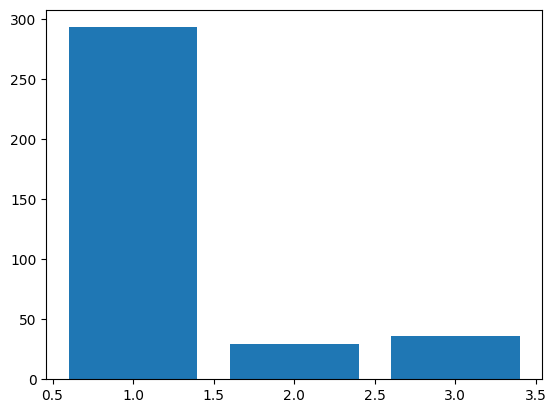

In [31]:
plt.bar([1,2,3], [293,29,36])

Догадки подтвердились, наибольшее количество гильдий не участвуют в клановых войнах и растут исключиьельно за счет миссий

Давайте посчитаем, а сколько пользователей вообще донатили в игру.

54.46886380271559


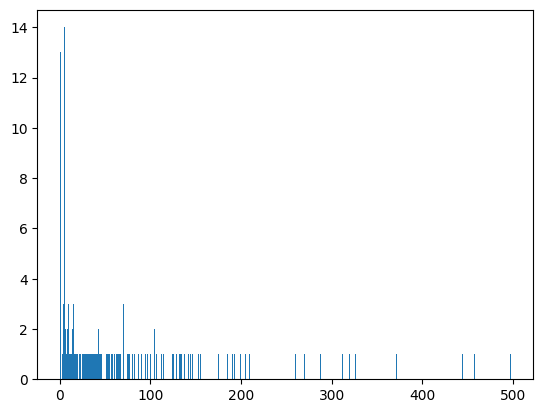

In [32]:
a = (merged_df1_df2.groupby('revenue').size().to_numpy())[:]
b = (merged_df1_df2.groupby('revenue').size().index.to_numpy())[:]
plt.bar(b, a)
print(merged_df1_df2['revenue'].mean())

In [33]:
simply([1,2,3,4,8,9,10,11],[100,50,20,10,1,1,1,1],3)

([1, 2, 4, 5, 0], [170, 12, 2, 0, 0])

<BarContainer object of 18 artists>

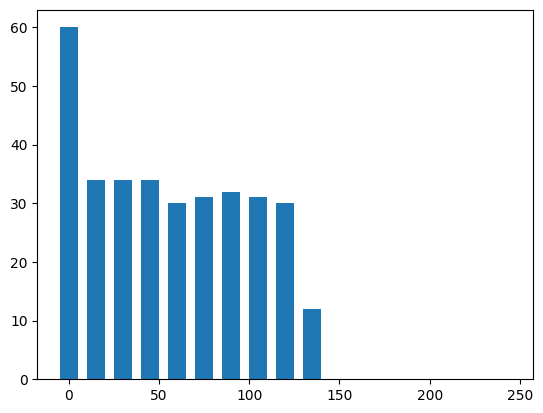

In [34]:
newb = []
for num in b:
    newb.append(int(num))
aa= simply(newb,a,30)[1]
bb = simply(newb,a,30)[0]
plt.bar(bb, aa,width=10)

In [35]:
simply(newb,a,30)

([0,
  15,
  30,
  45,
  60,
  75,
  90,
  105,
  120,
  135,
  150,
  165,
  180,
  195,
  210,
  225,
  240,
  0],
 [60, 34, 34, 34, 30, 31, 32, 31, 30, 12, 0, 0, 0, 0, 0, 0, 0, 0])

Вывод следующий: игра действительно стоит свеч, люди действительно донатят.

In [36]:
merged_df1_df2['n_seasons'].unique()

array([0., 1., 2., 3., 5.])

In [41]:
merged_df1_df2[merged_df1_df2['n_seasons'] < 1].iloc[:, 13:14].squeeze().mean()

52.830350877594476

In [45]:
merged_df1_df2[merged_df1_df2['n_seasons'] == 5].iloc[:, 13:14].squeeze().mean()

15.18

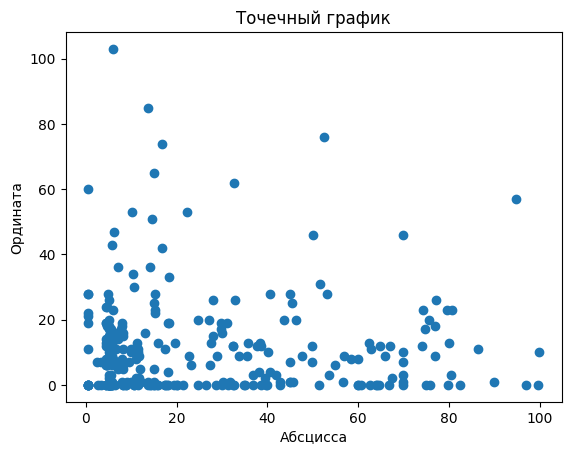

In [78]:
a = (merged_df1_df2[merged_df1_df2['revenue'] < 100].iloc[:, 13:14].to_numpy())[:]
b= (merged_df1_df2[merged_df1_df2['revenue'] < 100].iloc[:, 5:6].to_numpy())[:]
# Создаем точечный график
plt.scatter(a, b)

# Добавляем заголовок и метки осей
plt.title('Точечный график')
plt.xlabel('Абсцисса')
plt.ylabel('Ордината')

# Отображаем график
plt.show()

Как и ожиддалось, серьезной зависимости между количеством вложенных денег и между участием в гильдкеских активностях (таланты и клановые войны) нет. Безусловно, вкладывая деньги люди чуть более трепетно относятся к игре, однако это далеко не решающий фактор. Если какие-то механики игры плохи, то деньги их не сделают лучше, тем более, что люди вкладываются в игру ради других вещей


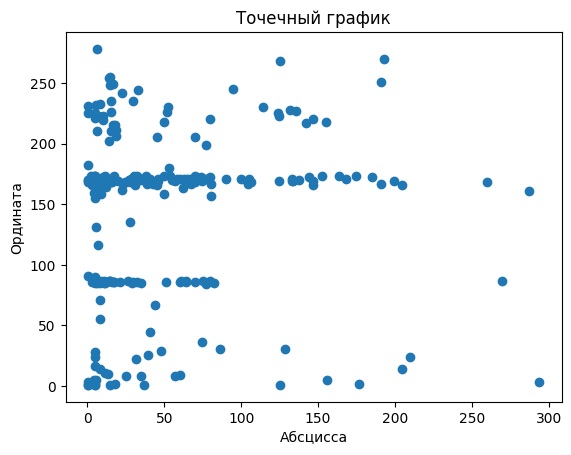

In [77]:
a = (merged_df1_df2[merged_df1_df2['revenue'] < 300].iloc[:, 13:14].to_numpy())[:]
b= (merged_df1_df2[merged_df1_df2['revenue'] < 300].iloc[:, 7:8].to_numpy())[:]
# Создаем точечный график
plt.scatter(a, b)

# Добавляем заголовок и метки осей
plt.title('Точечный график')
plt.xlabel('Абсцисса')
plt.ylabel('Ордината')

# Отображаем график
plt.show()

In [ ]:
а вот между миссиями и деньгами уже имеется некоторая кореляция. При этом интересный момент. Имеется 2 стационарных положения на миссиях. Вероятнее всего примерно на отметке в 90 и 160 миссий игрокам становится или не нужно, или трудно проходить игру.
Чтобы четко сказать, что происходит, нужно больше информации. Сейчас не понятно, хорош ли данный застой, или нет. 

ВЫВОД

По моему личному мнению было бы глупо вводить какие-то отдельные фичи для тех, кто вкладывает деньги в игру, ибо
1) Не рабочая система клановых войн как не работала, так и не будет работать.
2) Большая часть игроков не готова отдавать много денег за что-то внутриигровое, поэтому данная мера может подмочить нашу репутацию в глазах других игроков
3) Гильдии действительно хорошая идея, вот только необходимо переработать механику клановых войн. Возможно войны не очень интересуют игроков, или награды не такие существенные, а возможно есть какая-то иная причина, связанная с особенностями игры.
4) Игра находится в расцвете, существуют разные группы игроков, отличающиеся по уровню развития. Игрокам интересны миссии, да и донат на весьма хорошем уровне, поэтому, переработав командные активности в гильдиях можно будет вовлечь новых игроков, так что игру не стоит забрасывать